Using device: cpu
Roll Number is:102303276
value of ar=2.5
value of br=0.6


/tmp/ipython-input-227097859.py:29: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df=kagglehub.load_dataset(


100%|██████████| 5.22M/5.22M [00:01<00:00, 3.42MB/s]

Extracting zip of data.csv...


  stn_code       sampling_date           state   location agency  \
0      150  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1      151  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2      152  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3      150     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4      151     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1                         NaN    NaN  1990-02-01  
2                         NaN    NaN  1990-02-01  
3       

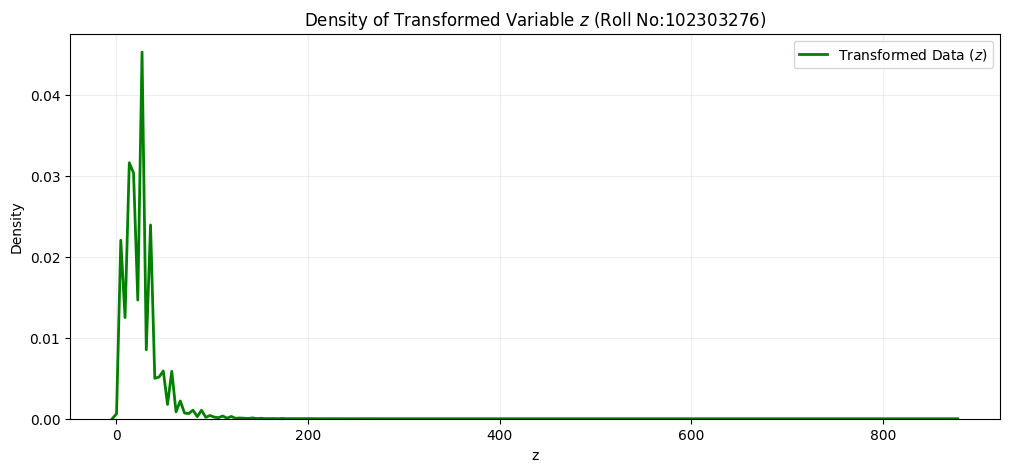

zt_tensor shape: torch.Size([419509, 1])
Epoch 0|D Loss:1.9886|G Loss:0.6063
Epoch 100|D Loss:0.5178|G Loss:1.1831
Epoch 200|D Loss:1.4012|G Loss:0.9438
Epoch 300|D Loss:1.5104|G Loss:0.8678
Epoch 400|D Loss:1.3958|G Loss:0.9309
Epoch 500|D Loss:1.3568|G Loss:0.7676
Epoch 600|D Loss:1.3918|G Loss:0.6116
Epoch 700|D Loss:1.3919|G Loss:0.6845
Epoch 800|D Loss:1.3897|G Loss:0.6964
Epoch 900|D Loss:1.3842|G Loss:0.6859
Epoch 1000|D Loss:1.3906|G Loss:0.7723
Epoch 1100|D Loss:1.3897|G Loss:0.7168
Epoch 1200|D Loss:1.3876|G Loss:0.7547
Epoch 1300|D Loss:1.3893|G Loss:0.6468
Epoch 1400|D Loss:1.3889|G Loss:0.7167
Epoch 1500|D Loss:1.3863|G Loss:0.7050
Epoch 1600|D Loss:1.3865|G Loss:0.7046
Epoch 1700|D Loss:1.3927|G Loss:0.6388


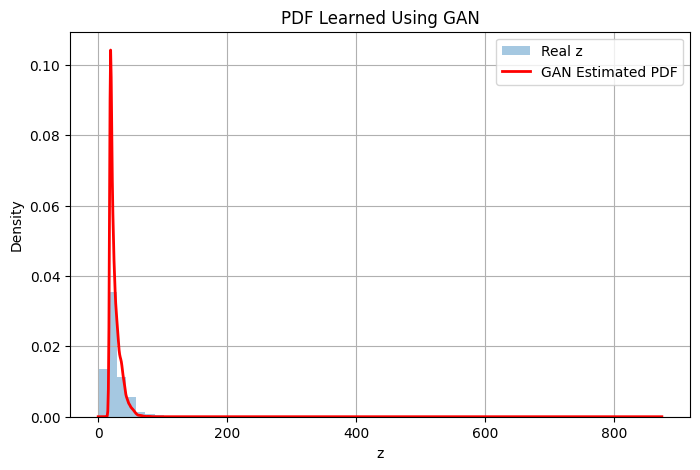

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(46)
torch.manual_seed(46)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",device)

roll=102303276

ar=0.5*(roll%7)
br=0.3*(roll%5+1)

print(f"Roll Number is:{roll}")
print(f"value of ar={ar}")
print(f"value of br={br}")

import kagglehub
from kagglehub import KaggleDatasetAdapter

df=kagglehub.load_dataset(
KaggleDatasetAdapter.PANDAS,
"shrutibhargava94/india-air-quality-data",
"data.csv",
pandas_kwargs={
"encoding":"ISO-8859-1",
"low_memory":False
}
)

print(df.head())

if "no2" not in df.columns:
 raise KeyError("CSV does not contain 'no2' column.")

x=df["no2"].dropna().astype(float).values

if x.size==0:
 raise ValueError("No valid NO2 values found.")

zt=x+ar*np.sin(br*x)

plt.figure(figsize=(12,5))

sns.kdeplot(
zt.flatten(),
color='green',
linewidth=2,
label='Transformed Data ($z$)'
)

plt.title(f'Density of Transformed Variable $z$ (Roll No:{roll})')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()
plt.grid(True,alpha=0.2)
plt.show()

zt_tensor=torch.tensor(zt,dtype=torch.float32).view(-1,1).to(device)
print("zt_tensor shape:",zt_tensor.shape)

class Generator(nn.Module):
 def __init__(self):
  super().__init__()
  self.net=nn.Sequential(
   nn.Linear(1,32),
   nn.ReLU(),
   nn.Linear(32,32),
   nn.ReLU(),
   nn.Linear(32,1)
  )
 def forward(self,x):
  return self.net(x)

class Discriminator(nn.Module):
 def __init__(self):
  super().__init__()
  self.net=nn.Sequential(
   nn.Linear(1,32),
   nn.ReLU(),
   nn.Linear(32,32),
   nn.ReLU(),
   nn.Linear(32,1),
   nn.Sigmoid()
  )
 def forward(self,x):
  return self.net(x)

G=Generator().to(device)
D=Discriminator().to(device)

criterion=nn.BCELoss()

opt_G=optim.Adam(G.parameters(),lr=0.001)
opt_D=optim.Adam(D.parameters(),lr=0.001)

epochs=1800
batch_size=128

for epoch in range(epochs):

 idx=np.random.randint(0,len(zt_tensor),batch_size)
 real_zt=zt_tensor[idx].to(device)

 real_labels=torch.ones(batch_size,1,device=device)
 fake_labels=torch.zeros(batch_size,1,device=device)

 noise=torch.randn(batch_size,1,device=device)
 fake_zt=G(noise)

 D_real=D(real_zt)
 D_fake=D(fake_zt.detach())

 loss_D=criterion(D_real,real_labels)+criterion(D_fake,fake_labels)

 opt_D.zero_grad()
 loss_D.backward()
 opt_D.step()

 noise=torch.randn(batch_size,1,device=device)
 fake_zt=G(noise)

 D_fake=D(fake_zt)

 loss_G=criterion(D_fake,real_labels)

 opt_G.zero_grad()
 loss_G.backward()
 opt_G.step()

 if epoch%100==0:
  print(f"Epoch {epoch}|D Loss:{loss_D.item():.4f}|G Loss:{loss_G.item():.4f}")

with torch.no_grad():
 z_fake=G(torch.randn(10000,1,device=device)).cpu().numpy().flatten()

kde=gaussian_kde(z_fake)

z_grid=np.linspace(min(zt),max(zt),1000)

pdf_est=kde(z_grid)

plt.figure(figsize=(8,5))

plt.hist(zt,bins=60,density=True,alpha=0.4,label="Real z")

plt.plot(z_grid,pdf_est,'r',linewidth=2,label="GAN Estimated PDF")

plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Learned Using GAN")

plt.legend()
plt.grid()
plt.show()